В данном задании вам нужно будет провести анализ данных проведенного A/B-теста.

Данные будут предоставлены в формате csv.gz. Они будут содержать также часть пред экспериментального этапа.

Описание эксперимента:
Есть мобильное приложение. В этом приложении у пользователей есть возможность покупать игровые предметы за реальные деньги. Чтобы стимулировать пользователей их покупать, приложение периодически предлагает пользователям товары - появляется окошко с рекомендацией купить товар. Отдел машинного обучения предложил улучшение для текущего алгоритма выбора рекомендации. Для проверки улучшений алгоритма был проведен A/B тест. Лог его проведения предоставлен в прикрепленном файле. 

Метрика: средний доход от пользователя за 1 неделю после первого показа ему рекомендации на 10% (после начала A/B теста время первого показа ищется снова)

Важная информация:
Эксперимент начинается 2023-05-01. Данные есть до 2023-06-01 (но можно завершить раньше, если это позволит оценка длительности)
Вам сказали, что его длительность должна составить 1 месяц.
Все покупки, которые вызваны не влиянием рекомендаций, в этом логе не учитываются

Описание данных:
id_product -  идентификатор продукта, который был рекомендован
is_pay - купил ли пользователь товар
sum_payment - размер платежа (0, если не купил)
city - город, в котором находится пользователь
id_user - пользователь
timestamp - timestamp события
date - дата события
group - группа пользователей (None, если данные не из АБ-теста)

Задачи, которые необходимо решить:
Оценить длительность теста на момент его начала. Сравнить с предложенной. Для оценки необходимо использовать данные с пред экспериментального периода. Посмотреть, есть ли выбросы в данных.
Построить методику расчета целевой метрики. Рассчитать целевую метрику на день окончания теста (рассчитанной в п1) для группы A и B, рассчитать эффект, p_value. Посмотреть, есть ли выбросы в данных.
Рассчитать метрики из п2 по дням и построить их графики.
Принять решение о результате теста - обосновать.

Дополнительно:
При подсчете метрик обработать выбросы в данных - описать почему их можно удалить из теста, если они удаляются. Пожалуйста, не заглядывайте в будущее по данным, если рассчитанная длительность меньше предоставленных данных.

In [1]:
#!pip install pyarrow

In [2]:
from datetime import timedelta
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("ab_hse_4.csv", engine="pyarrow", dtype={'timestamp':np.int64, 'id_user':str, 'sum_payment':np.int64, 'group':str, 'city':str, 'id_product':np.float64, 'is_pay':np.int64})
df.head()
# Возникла проблема с типами в колонке sum_payment. Нужно как-то её обойти

,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date
0,1680330573,user_9903,27,,Санкт-Петербург,4.0,1,2023-04-01
1,1680332652,user_6732,0,,Рязань,1.0,0,2023-04-01
2,1680378039,user_4199,0,,Москва,3.0,0,2023-04-01
3,1680337580,user_3606,12,,Санкт-Петербург,7.0,1,2023-04-01
4,1680334389,user_9519,0,,Санкт-Петербург,14.0,0,2023-04-01


Создаём 3 группы:

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df_preexp = df[df.group == '']
df_A = df[df.group == 'A']
df_B = df[df.group == 'B']
df_preexp.head()

,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date
0,2023-04-01 06:29:33,user_9903,27,,Санкт-Петербург,4.0,1,2023-04-01
1,2023-04-01 07:04:12,user_6732,0,,Рязань,1.0,0,2023-04-01
2,2023-04-01 19:40:39,user_4199,0,,Москва,3.0,0,2023-04-01
3,2023-04-01 08:26:20,user_3606,12,,Санкт-Петербург,7.0,1,2023-04-01
4,2023-04-01 07:33:09,user_9519,0,,Санкт-Петербург,14.0,0,2023-04-01


In [5]:
# Визуализация и удаление выбросов с помощью прямоугольного графика
def group_info(var):
    sns.boxplot(var.values)
    plt.show()
    print(var.value_counts())
    
def show_stats(data, name):
    print(f'{name}: Среднее: {data.mean():.2f}, Дисперсия: {data.var():.2f}, Ср.кв.отклонение: {data.std():.2f}')

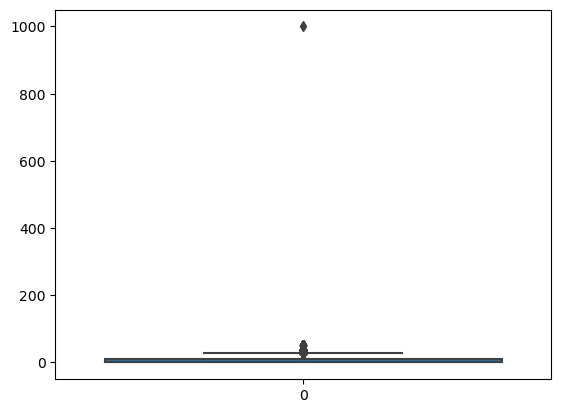

sum_payment
0       19117
13       1506
31        632
14        539
20        530
12        524
28        496
37        496
11        449
36        346
22        250
19        238
25        203
38        122
10        105
27         84
16         69
53         52
1000        1
Name: count, dtype: int64


In [6]:
group_info(df_preexp.sum_payment)

На приведенном выше графике хорошо видно, что значение равные 1000 действует как выброс.<br>
Оно единственное и, возможно, его можно исключить.<br>
Проверим его содержимое:

In [7]:
df_preexp[df_preexp['sum_payment']==1000]

,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date
2705,2023-04-13 02:49:49,user_0,1000,,Москва,NaN,1,2023-04-13


user_0 - скорее всего относится к тестовому пользователю.<br>
Ночное время, скорее всего, нетипично для обычных пользователей.<br>
Пустое значение поля id_product и круглая сумма наводит на мысль, что данные добавлены искуственно.<br>
Исключим их.

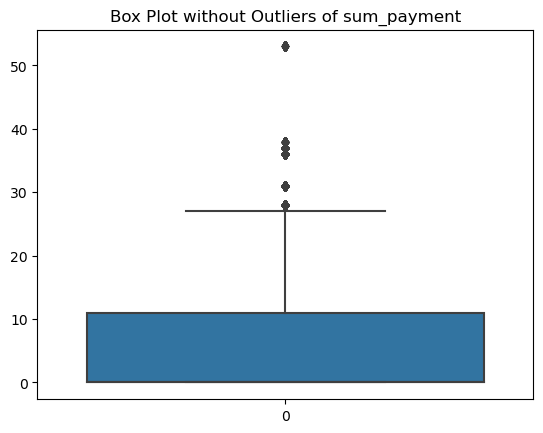

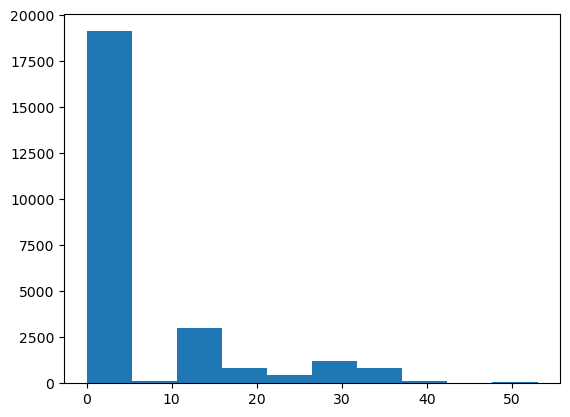

In [8]:
def removal_Box_plot(df, column, threshold):
    removed_outliers = df[df[column] < threshold]

    sns.boxplot(removed_outliers[column].values)
    plt.title(f'Box Plot without Outliers of {column}')
    plt.show()
    return removed_outliers

threshold_value = 1000
no_outliers = removal_Box_plot(df_preexp, 'sum_payment', threshold_value)
# Посмотрим на итог в виде гистограммы
plt.hist(no_outliers.sum_payment)
plt.show()

Большое число нулевых значений также является выбросом, но
отбрасывать их нельзя, т.к. это реальность.<br>
Чаще всего игровой процесс не включает покупку.

In [9]:
def calc_duration(k, effect, sigma2_A, sigma2_B, alpha, beta):
    z_A = stats.norm.ppf(1 - alpha/2)
    z_B = stats.norm.ppf(1 - beta)
    z = z_A + z_B
    n = (k + 1) * z**2 * (sigma2_A + sigma2_B/k)/(effect**2)
    return np.ceil(n)

def metric_step(df, end_exp, step = timedelta(days=7)):
    min_date = df.groupby('id_user').date.min().reset_index(name='start_date')
    min_date['date_step'] = min_date['start_date'] + step
    data_user = df.merge(min_date, on='id_user')
    
    metrics_users = data_user[
        (data_user.date>=data_user.start_date) &
         (data_user.date<=data_user.date_step) &
        (data_user.date_step<=pd.to_datetime(end_exp, format='%Y-%m-%d'))
    ]
    metr = metrics_users.groupby('id_user').sum_payment.sum().tolist() # сумма за неделю
    
    return np.array(metr)

In [10]:
alpha = 0.05 # вероятность отвергнуть H0
beta = 0.8 # мощность

metrics = metric_step(no_outliers, '2023-05-01', step=timedelta(days=7))

sigma2_A = sigma2_B = metrics.var()
effect = 0.1 * metrics.mean()
k = df_A.id_user.nunique() /df_B.id_user.nunique()
size = int(calc_duration(k, effect, sigma2_A, sigma2_B, alpha, 1-beta))

Начало A/B теста 2023-05-01
Дата окончания теста для группы А: 2023-06-01 00:00:00
Дата окончания теста для группы B: 2023-06-01 00:00:00


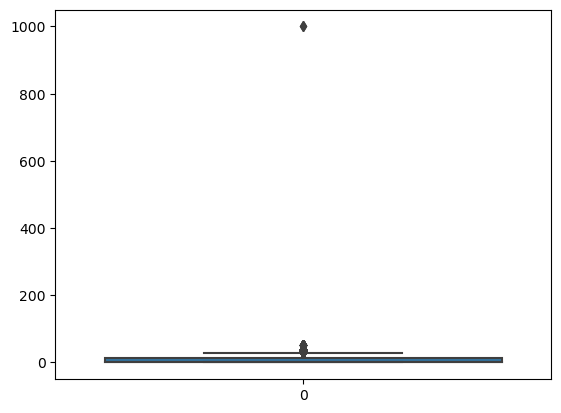

sum_payment
0       11020
13        926
14        399
31        370
12        363
37        352
20        348
28        330
11        315
36        224
25        164
22        143
19        129
38         92
10         76
16         52
53         43
27         41
1000        2
Name: count, dtype: int64


In [11]:
def time_duration(df, start_time, end_time, duration, step = timedelta(days=7)):
    date = start_time + step
    while True:
        if date >= end_time:
            return date
        size_group = len(metric_step(df[df.date <= date], date))
        if size_group >= duration:
            return date
        date += timedelta(days=1)
        
time_end_A = time_duration(df_A,
              pd.to_datetime('2023-05-01', format='%Y-%m-%d'), 
              pd.to_datetime('2023-06-06', format='%Y-%m-%d'), size//2)
time_end_B = time_duration(df_B,
              pd.to_datetime('2023-05-01', format='%Y-%m-%d'), 
              pd.to_datetime('2023-06-06', format='%Y-%m-%d'), size//2)

date_end = max(time_end_B, time_end_A)

print('Начало A/B теста 2023-05-01')
print(f"""Дата окончания теста для группы А: {time_end_A}""")
print(f"""Дата окончания теста для группы B: {time_end_B}""")

df_A = df_A[df_A.date <= date_end]
df_B = df_B[df_B.date <= date_end]

group_info(df_A.sum_payment)

В данных есть выброс, аналогичный предыдущей серии.<br>
Проверим его содержимое:

In [12]:
df_A[df_A.sum_payment == 1000]

,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date
26242,2023-05-05 21:00:00,user_11998,1000,A,Москва,NaN,1,2023-05-06
26272,2023-05-05 21:00:00,user_11996,1000,A,Москва,NaN,1,2023-05-06


В этот раз поле id_user отличается, не будем больше на него ориентироватья.<br>
Время ровно 21:00:00 выглядит искусственным.<br>
Пустое значение поля id_product и круглая сумма наводит на мысль, что данные добавлены искуственно.<br>
Исключим их.

Группа A org: Среднее: 6.13, Дисперсия: 246.60, Ср.кв.отклонение: 15.70


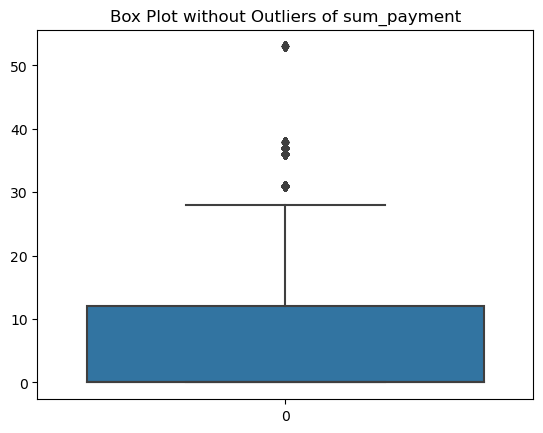

Группа A new: Среднее: 6.00, Дисперсия: 118.22, Ср.кв.отклонение: 10.87
Группа А     : Среднее: 6.00, Дисперсия: 118.22, Ср.кв.отклонение: 10.87
Группа B     : Среднее: 6.58, Дисперсия: 125.06, Ср.кв.отклонение: 11.18
Группа предв.: Среднее: 5.48, Дисперсия: 147.43, Ср.кв.отклонение: 12.14


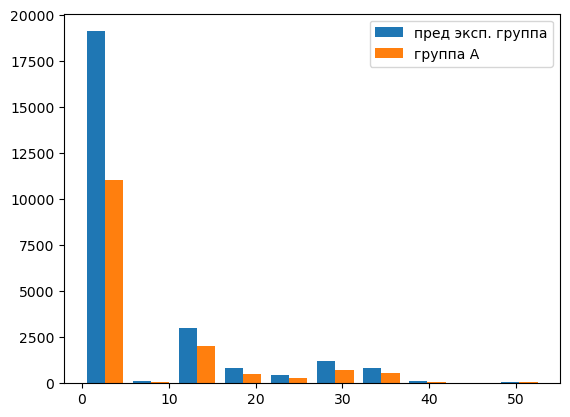

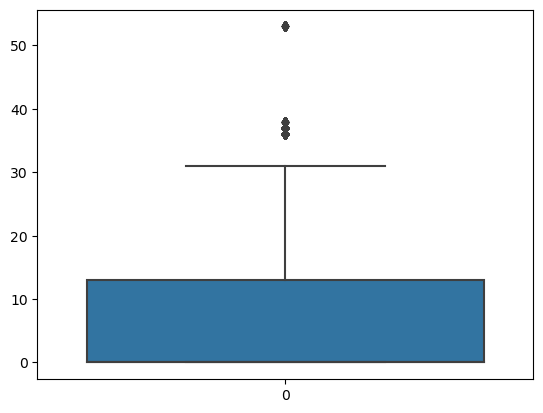

sum_payment
0     10484
13     1111
31      412
14      398
37      393
12      367
20      347
11      347
28      331
36      235
22      178
25      160
19      155
10       89
38       88
27       66
16       49
53       47
Name: count, dtype: int64


In [13]:
threshold_value = 1000
show_stats(df_A['sum_payment'], 'Группа A org')
df_A = removal_Box_plot(df_A, 'sum_payment', threshold_value)
show_stats(df_A['sum_payment'], 'Группа A new')

show_stats(df_A['sum_payment'], 'Группа А     ')
show_stats(df_B['sum_payment'], 'Группа B     ')
show_stats(df_preexp['sum_payment'], 'Группа предв.')

plt.hist([no_outliers.sum_payment, df_A.sum_payment],  label=['пред эксп. группа', 'группа А'])
plt.legend(loc='upper right')
plt.show()

group_info(df_B.sum_payment)

In [14]:
def get_bootstrap_stat_interval(sample_data, stat_func, n_samples, confidence_level):
    bootstrap_indices = np.random.randint(0, len(sample_data), (n_samples, len(sample_data)))
    bootstrap_stats = stat_func(sample_data[bootstrap_indices], axis=1)
    lower_bound = np.percentile(bootstrap_stats, 100 * (1 - confidence_level) / 2)
    upper_bound = np.percentile(bootstrap_stats, 100 * (1 - (1 - confidence_level) / 2))
    return lower_bound, upper_bound

def plot_histogram_with_confidence_interval(data, ci, title):
    plt.hist(data, bins=50, alpha=0.9)
    plt.axvline(x=ci[0], color='orangered', linestyle='--')
    plt.axvline(x=ci[1], color='orangered', linestyle='--')
    plt.title(title + f'\nInterval: [{ci[0]:.3f}; {ci[1]:.3f}]')
    plt.show()

def display_distribution_info(distribution, label, n_bootstrap_samples, confidence_level):
    # Преобразовываем Series в numpy array
    distribution_array = distribution.to_numpy()
    
    mean_ci = get_bootstrap_stat_interval(distribution_array, np.mean, n_bootstrap_samples, confidence_level)
    print(f"{label}\nConfidence interval for the mean: [{mean_ci[0]:.3f}; {mean_ci[1]:.3f}]")
    plot_histogram_with_confidence_interval(distribution_array, mean_ci, f'Доверительный интервал для среднего значения: {label}')

def calculate_metrics(group_a, group_b, start_date_str, end_date_str, interval=timedelta(days=1)):
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)
    current_date = start_date + timedelta(days=7)
    
    records = []
    
    while current_date <= end_date:
        metric_a = group_a[group_a.date < current_date].sum_payment
        metric_b = group_b[group_b.date < current_date].sum_payment
        t_stat, p_value = stats.ttest_ind(metric_a, metric_b)
        records.append({
            'date': current_date,
            'mean_metric_a': np.mean(metric_a),
            'mean_metric_b': np.mean(metric_b),
            'effect_size': np.mean(metric_a) - np.mean(metric_b),
            'p_value': p_value
        })
        current_date += interval
        
    return pd.DataFrame(records), metric_a, metric_b

Метрики группы A
Confidence interval for the mean: [5.997; 6.008]


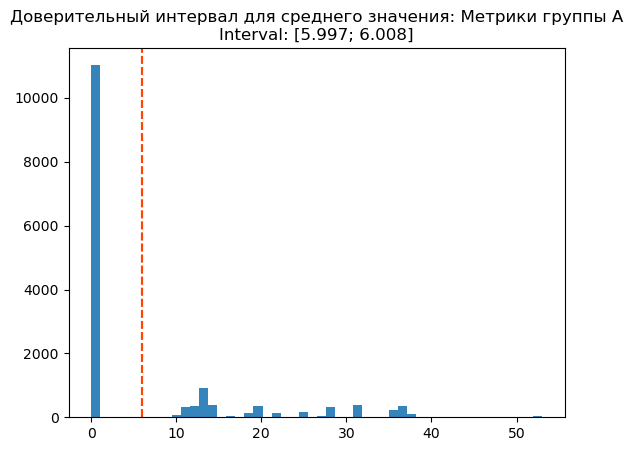

Метрики группы B
Confidence interval for the mean: [6.575; 6.586]


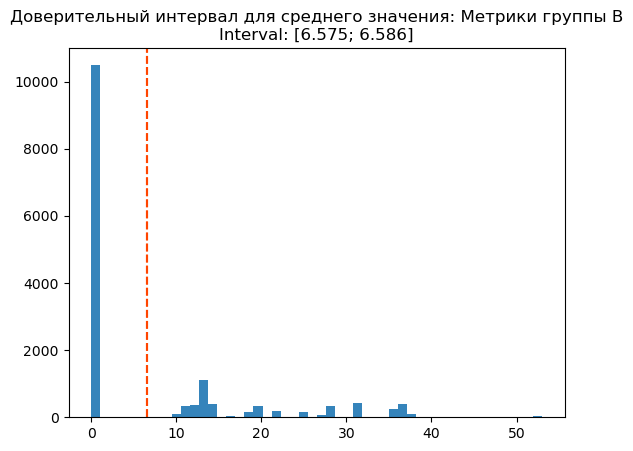

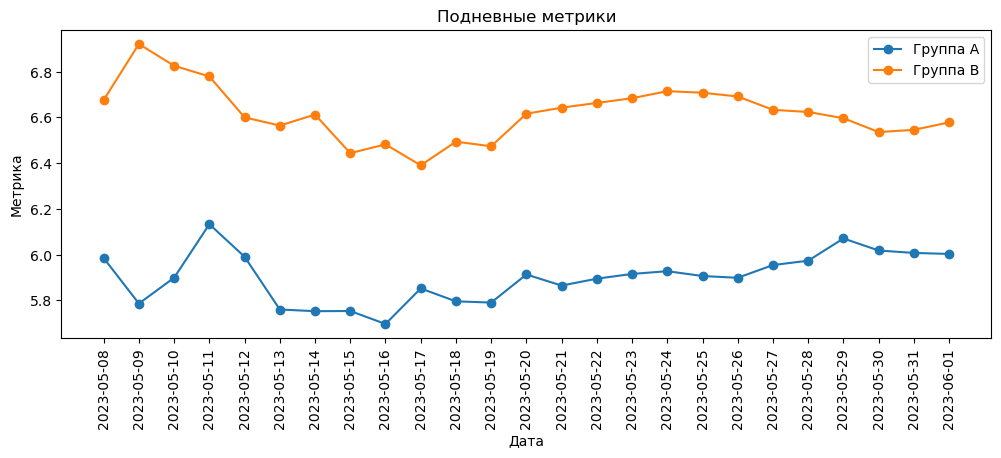

In [15]:
end_date_experiment = '2023-06-01'

# Предполагается, что df_A и df_B уже определены ранее в коде
daily_metrics, metrics_a, metrics_b = calculate_metrics(df_A, df_B, '2023-05-01', end_date_experiment)

display_distribution_info(metrics_a, 'Метрики группы A', 1000, 0.05)
display_distribution_info(metrics_b, 'Метрики группы B', 1000, 0.05)

plt.figure(figsize=(12, 4))
plt.title('Подневные метрики')
plt.plot(daily_metrics.date, daily_metrics.mean_metric_a, label='Группа A', marker='o')
plt.plot(daily_metrics.date, daily_metrics.mean_metric_b, label='Группа B', marker='o')
plt.xticks(daily_metrics.date, rotation=90)
plt.xlabel('Дата')
plt.ylabel('Метрика')
plt.legend()
plt.show()

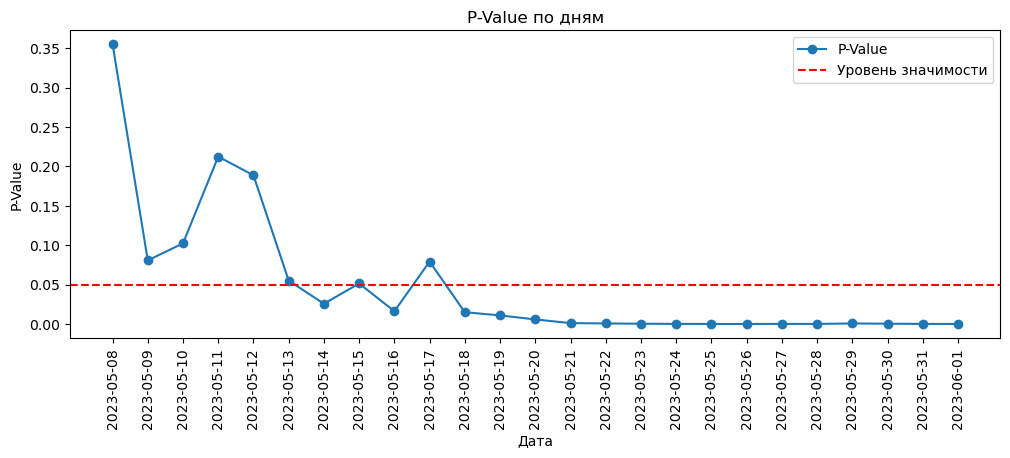

Отклоняем H0: Группы статистически различаются.


In [16]:
plt.figure(figsize=(12, 4))
plt.plot(daily_metrics.date, daily_metrics.p_value, label='P-Value', marker='o')
plt.axhline(y=0.05, color='red', linestyle='--', label='Уровень значимости')

plt.xticks(daily_metrics.date, rotation=90)
plt.title('P-Value по дням')
plt.xlabel('Дата')
plt.ylabel('P-Value')
plt.legend()
plt.show()

# Обратите внимание, что для принятия решения о гипотезе мы берем только последнюю строку датафрейма
if daily_metrics[daily_metrics.date == pd.to_datetime(end_date_experiment)].p_value.values[0] < 0.05:
    print('Отклоняем H0: Группы статистически различаются.')
else:
    print('Не удалось отклонить H0: существенных различий между группами нет.')